In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import numpy as np
import matplotlib.pyplot as plt
fig_width = 12
%matplotlib inline


# the switching binomial generative model


In [2]:
import bayesianchangepoint as bcp

seed = 51 #119 #2017 # 42
np.random.seed(seed)

N_blocks = 3 # 4 blocks avant
N_trials = 500
tau = N_trials/6.
h = 1/tau
(trials, p) = bcp.switching_binomial_motion(N_trials=N_trials, N_blocks=N_blocks, tau=tau, seed=seed, Jeffreys=False)


## performing inference: application to synthetic data

i_block= 0


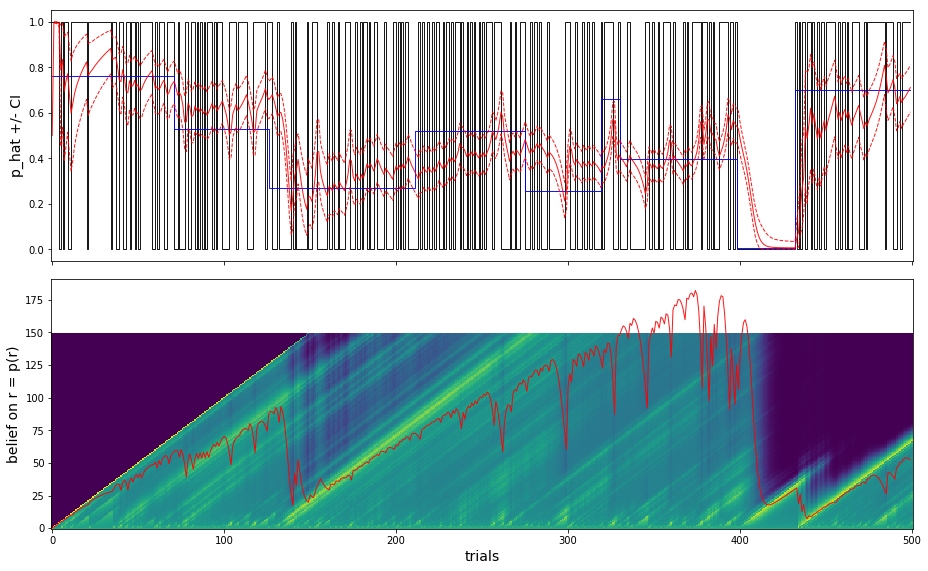

i_block= 1


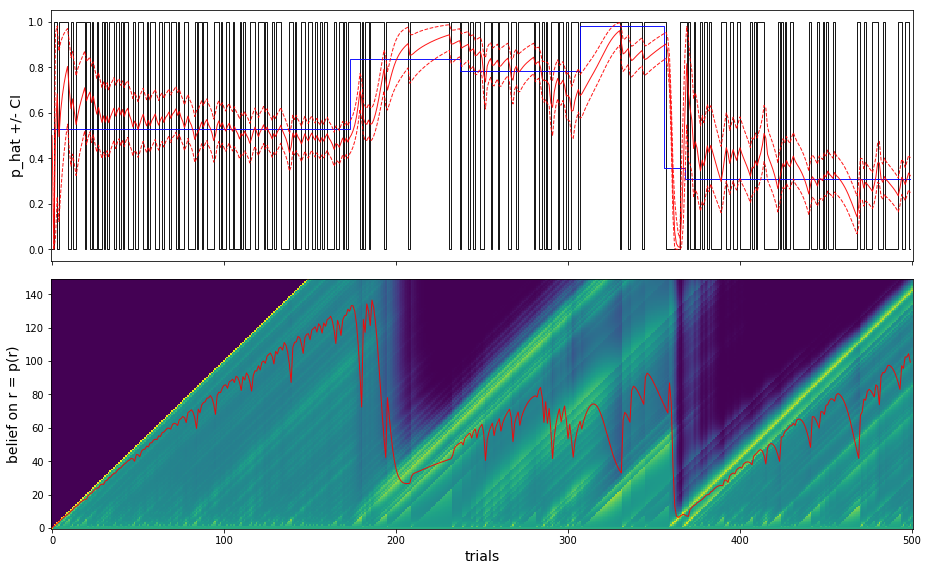

i_block= 2


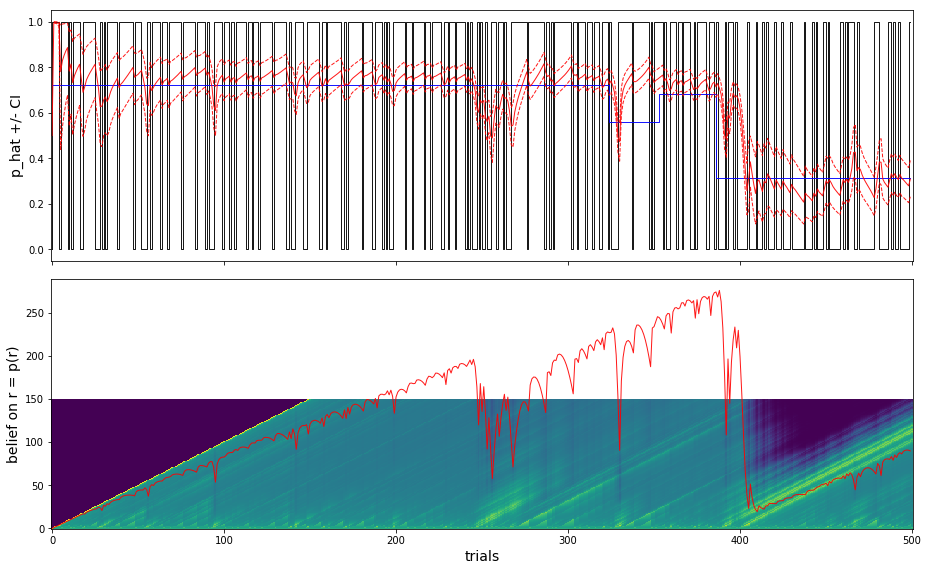

In [3]:
for i_block in range(3):
    print('i_block=', i_block)
    o = p[:, i_block, 0]
    p_bar, r, beliefs = bcp.inference(o, h=h, p0=.5)
    fig, axs = bcp.plot_inference(p[:, i_block, 0], p[:, i_block, 1], p_bar, r, beliefs, max_run_length=150)
    plt.show()

## testing different hazard rates

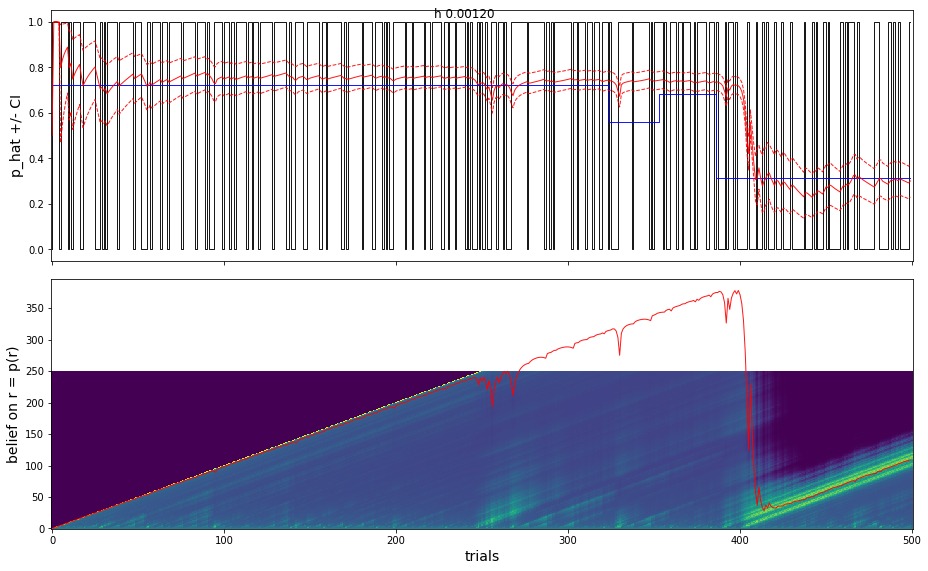

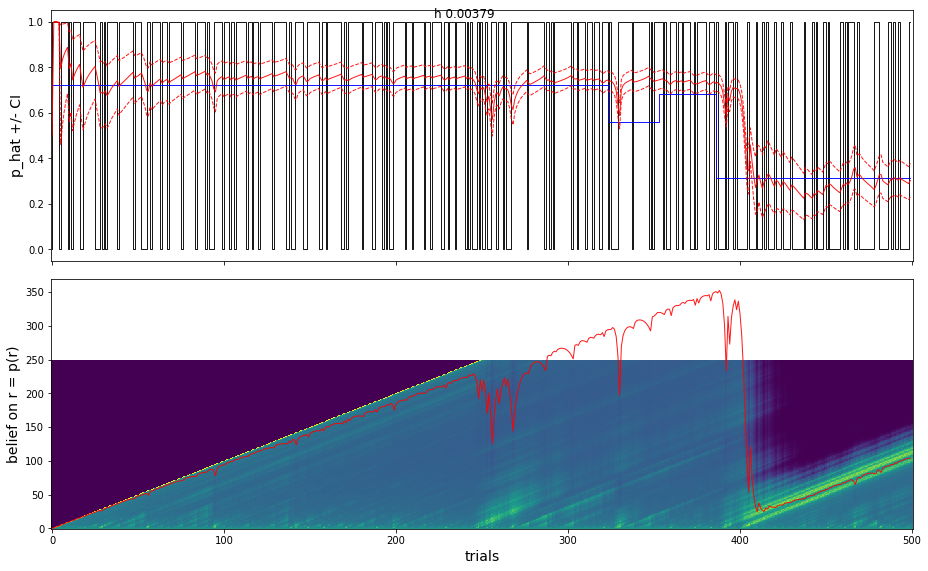

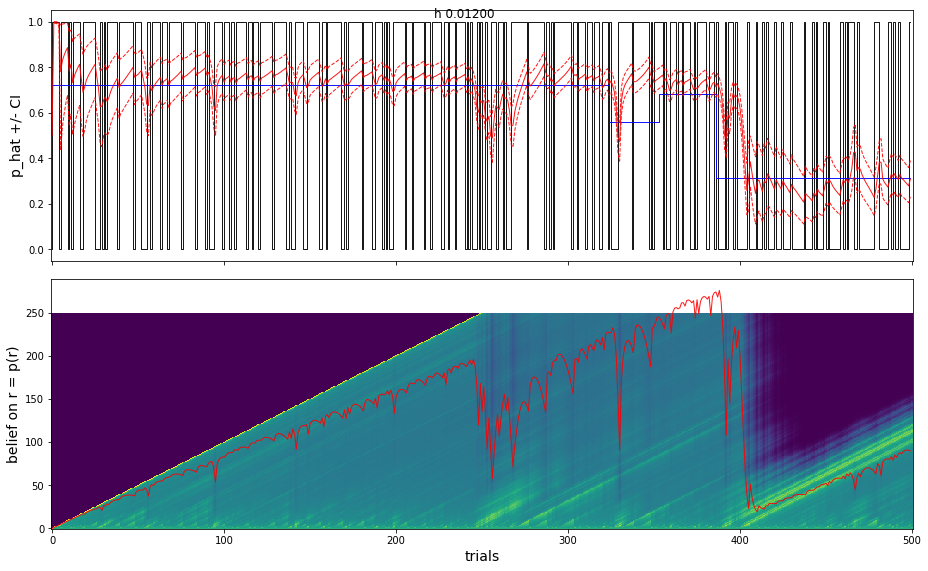

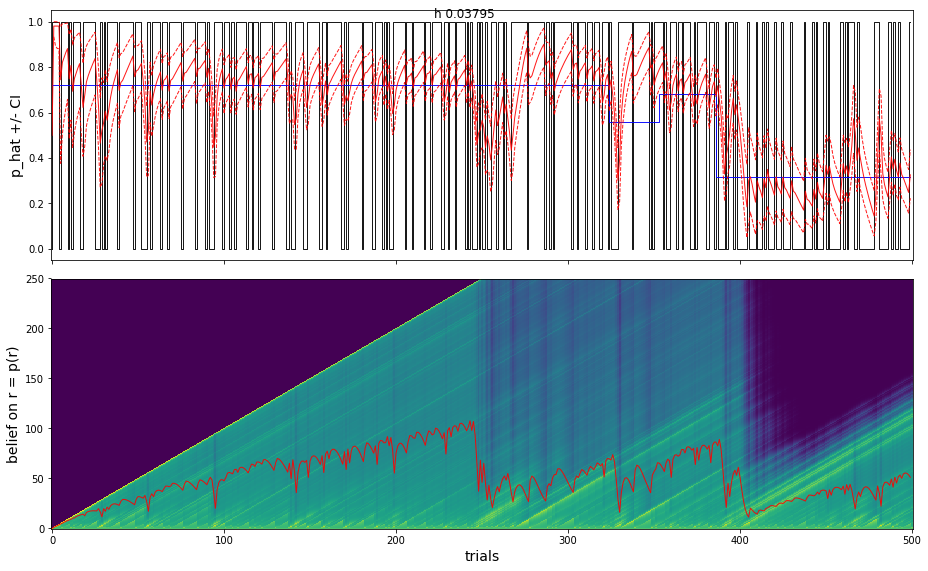

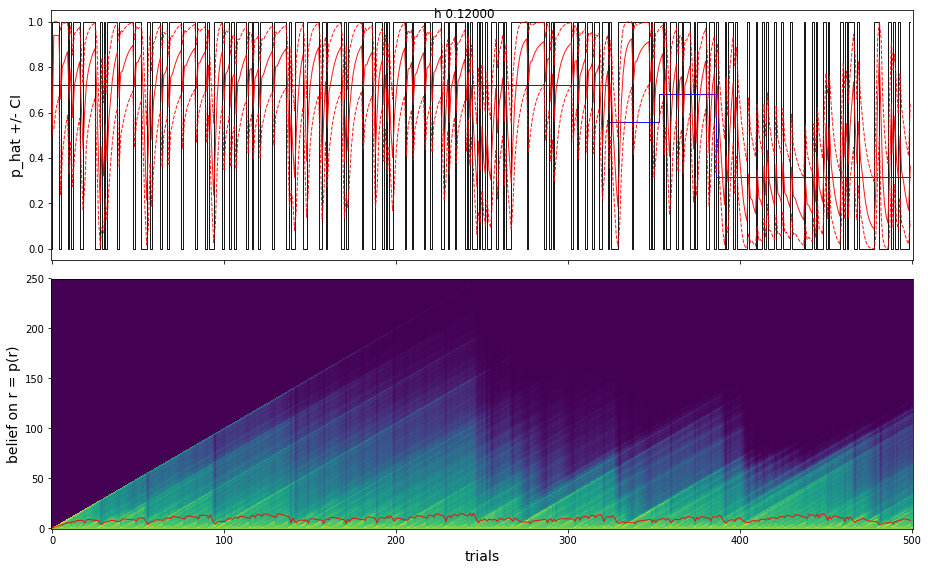

In [4]:
hs = h*np.logspace(-1., 1., 5)
for h_ in hs:
    o = p[:, i_block, 0]
    p_bar, r, beliefs = bcp.inference(o, h=h_, p0=.5)
    fig, axs = bcp.plot_inference(o, p[:, i_block, 1], p_bar, r, beliefs, max_run_length=250)
    fig.suptitle('h %.5f' % h_)
    plt.show()

## evaluating the best hazard rate using a likelihood score

In [ ]:
N_scan = 15
N_blocks = 10 # 4 blocks avant

(trials, p) = bcp.switching_binomial_motion(N_trials=N_trials, N_blocks=N_blocks, tau=tau, seed=seed, Jeffreys=False)

hs = h*np.logspace(-2, 2, N_scan)
modes = ['expectation', 'max']
score = np.zeros((len(modes), N_scan, N_blocks))
for i_mode, mode in enumerate(modes):
    for i_block in range(N_blocks):
        o = p[:, i_block, 0]
        for i_scan, h_ in enumerate(hs):
            p_bar, r, beliefs = bcp.inference(o, h=h_, p0=.5)
            p_hat, r_hat = bcp.readout(p_bar, r, beliefs, mode=mode)
            score[i_mode, i_scan, i_block] = np.mean(np.log2(1.e-12+bcp.likelihood(o, p_hat, r_hat)))
            

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for i_mode, mode in enumerate(modes):
    ax.errorbar(hs, np.mean(score[i_mode, ...], axis=1), yerr=np.std(score[i_mode, ...], axis=1), label=mode)

ax.vlines(h, ymin=np.nanmin(score), ymax=np.nanmax(score), lw=2, label='true')
ax.set_xscale("log")#, nonposx='clip')

ax.set_xlabel('Hazard rate')
ax.set_ylabel('Mean log-likelihood (bits)')
ax.legend();